In [1]:
import os
import re

import dlib
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

from face_swap import warp_image_2d, warp_image_3d, mask_from_points, apply_mask, correct_colours, transformation_from_points

In [2]:
path = "./data"

In [3]:
def open_img(name, scale=1.):
    img = cv2.imread(os.path.join(path, name))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, (int(img.shape[1]*scale), int(img.shape[0]*scale)), Image.LANCZOS)
    return img

def show_img(img, figsize=(7, 14)):
    plt.figure(figsize=figsize)
    plt.imshow(img)
    plt.show()

In [4]:
me = open_img("me.jpg", scale=0.15)
crowd = open_img("asians.jpg")

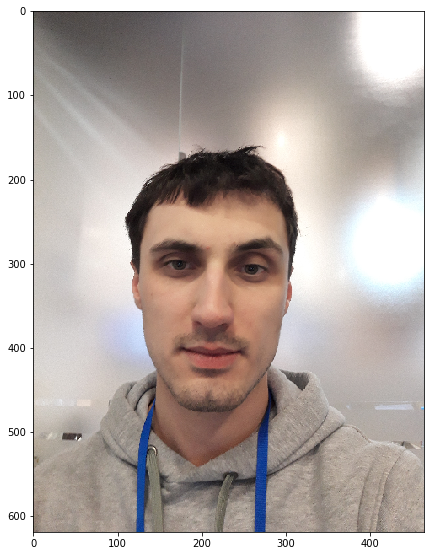

In [94]:
show_img(me)

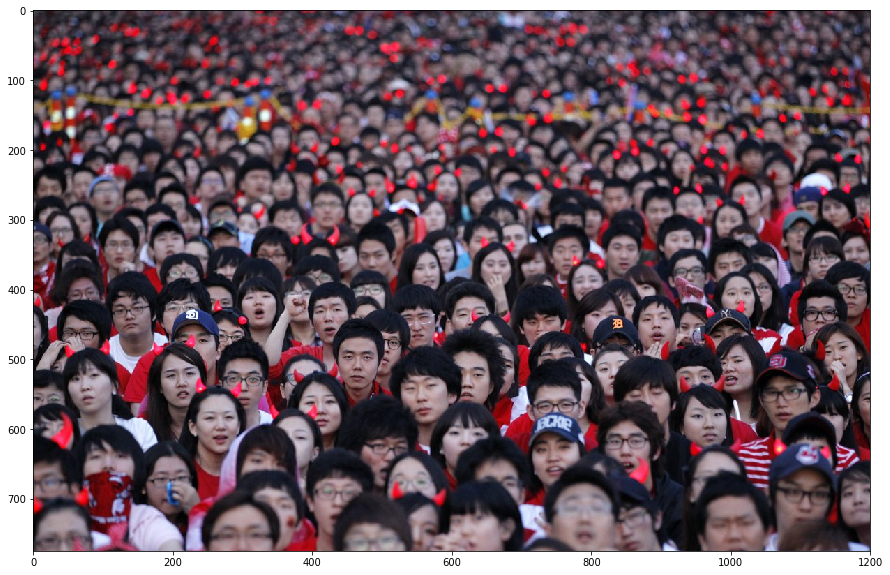

In [11]:
show_img(crowd, figsize=(15, 25))

In [5]:
def crop_face(img, bboxs, offset=10):
    imgs = []
    for bbox in bboxs:
        x = bbox[0] 
        y = bbox[1]
        w = bbox[2] - x
        h = bbox[3] - y

        x = max(x - offset//2, 0)
        y = max(y - offset//2, 0)
        w = min(img.shape[0], w + offset)
        h = min(img.shape[1], h + offset)
        imgs.append(img[y:y+h, x:x+w])
    return imgs

def face_detection(img):
    # Ask the detector to find the bounding boxes of each face. The 1 in the
    # second argument indicates that we should upsample the image 1 time. This
    # will make everything bigger and allow us to detect more faces.
    detector = dlib.get_frontal_face_detector()
    faces = detector(img, 1)
    bboxs = []

    for face in faces:
        bboxs.append((face.left(), face.top(), face.right(), face.bottom()))
    
    return bboxs

def face_points_detection(img, bbox):
    # Get the landmarks/parts for the face in box d.
    shape = predictor(img, bbox)

    # loop over the 68 facial landmarks and convert them
    # to a 2-tuple of (x, y)-coordinates
    coords = [(shape.part(i).x, shape.part(i).y) for i in range(68)]

    # return the list of (x, y)-coordinates
    return coords

def select_faces(im, points, r=10):
    im_w, im_h = im.shape[:2]
    left, top = np.min(points, 0)
    right, bottom = np.max(points, 0)
    
    x, y = max(0, left-r), max(0, top-r)
    w, h = min(right+r, im_h)-x, min(bottom+r, im_w)-y

    return points - np.asarray([[x, y]]), (x, y, w, h), im[y:y+h, x:x+w]

def preprocess_img(img, r=10):
    bboxs = face_detection(img)
    results = []
    for bbox in bboxs:
        points = face_points_detection(img, dlib.rectangle(*bbox))
        results.append(select_faces(img, points, r))
    return results

In [6]:
bboxs = face_detection(me)
crops = crop_face(me, bboxs, offset=10)

In [7]:
bboxs = face_detection(crowd)
crops = crop_face(crowd, bboxs, offset=10)

In [175]:
len(crops)

52

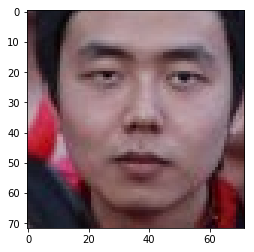

In [176]:
plt.imshow(crops[0])
plt.show()

In [8]:
PREDICTOR_PATH = 'models/shape_predictor_68_face_landmarks.dat'
predictor = dlib.shape_predictor(PREDICTOR_PATH)

In [9]:
dst_faces = preprocess_img(crowd, r=10)

In [10]:
len(dst_faces)

52

In [11]:
src_faces = preprocess_img(me, r=10)

In [12]:
len(src_faces)

1

python main.py --src imgs/test6.jpg --dst imgs/test7.jpg --out results/output6_7_2d.jpg --correct_color --warp_2d

In [13]:
warp_2d = True
correct_color = True
max_points = 68

dst_points, dst_shape, dst_face = dst_faces[1]
src_points, src_shape, src_face = src_faces[0]

In [15]:
w, h = dst_face.shape[:2]

### Warp Image
if not warp_2d:
    ## 3d warp
    warped_src_face = warp_image_3d(src_face, src_points[:max_points], dst_points[:max_points], (w, h))
else:
    ## 2d warp
    src_mask = mask_from_points(src_face.shape[:2], src_points, radius=2)
    src_face = apply_mask(src_face, src_mask)
    # Correct Color for 2d warp
    if correct_color:
        warped_dst_img = warp_image_3d(dst_face, dst_points[:max_points], 
                                       src_points[:max_points], src_face.shape[:2])
        src_face = correct_colours(warped_dst_img, src_face, src_points)
    # Warp
    warped_src_face = warp_image_2d(src_face, transformation_from_points(dst_points, src_points), (w, h, 3))

## Mask for blending
mask = mask_from_points((w, h), dst_points)
mask_src = np.mean(warped_src_face, axis=2) > 0
mask = np.asarray(mask*mask_src, dtype=np.uint8)

## Correct color
if not warp_2d and correct_color:
    warped_src_face = apply_mask(warped_src_face, mask)
    dst_face_masked = apply_mask(dst_face, mask)
    warped_src_face = correct_colours(dst_face_masked, warped_src_face, dst_points)

# ## Shrink the mask
# kernel = np.ones((5, 5), np.uint8)
# mask = cv2.erode(mask, kernel, iterations=1)

##Poisson Blending
r = cv2.boundingRect(mask)
center = ((r[0] + int(r[2] / 2), r[1] + int(r[3] / 2)))
output = cv2.seamlessClone(warped_src_face, dst_face, mask, center, cv2.NORMAL_CLONE)

x, y, w, h = dst_shape
dst_img_cp = crowd.copy()
dst_img_cp[y:y+h, x:x+w] = output
new_output = output.copy()
output = dst_img_cp

# dir_path = os.path.dirname(args.out)
# if not os.path.isdir(dir_path):
#     os.makedirs(dir_path)

# cv2.imwrite(args.out, output)

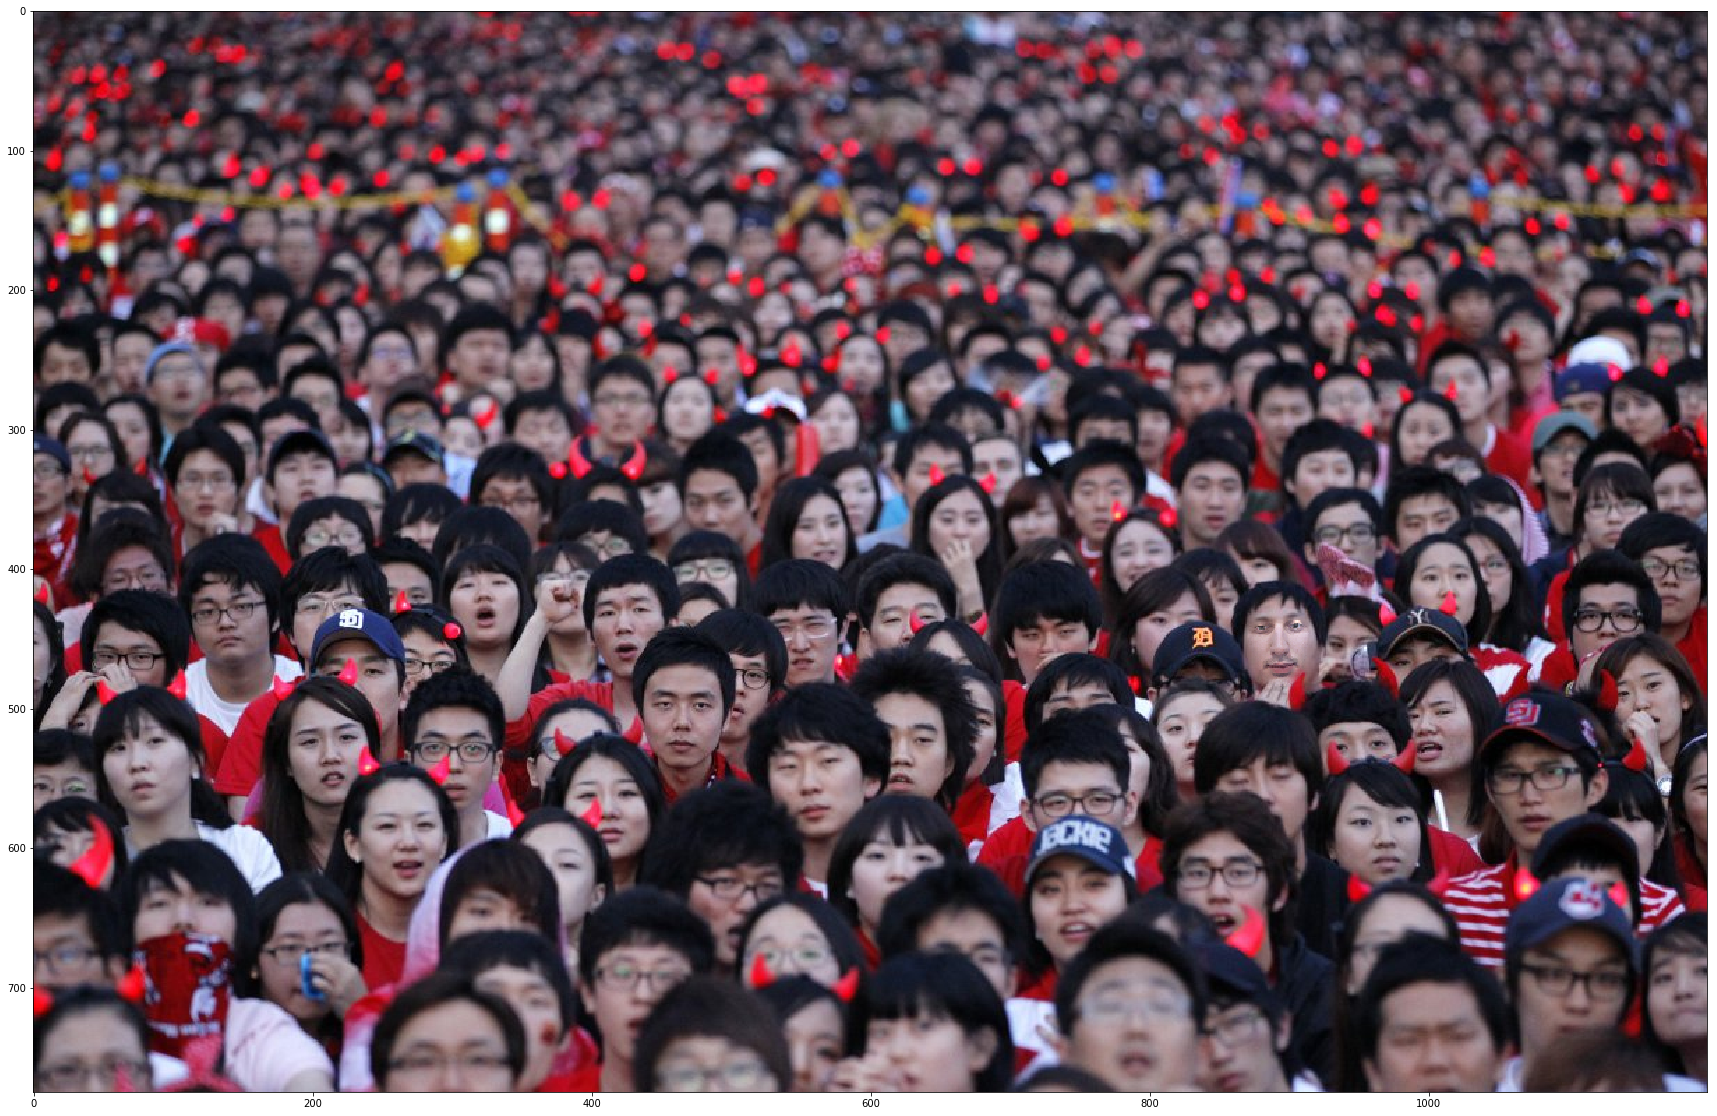

In [22]:
show_img(output, figsize=(30, 60))

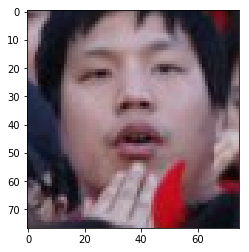

In [16]:
plt.imshow(dst_face)

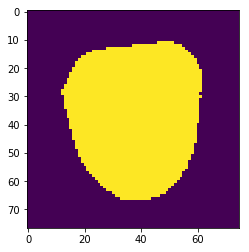

In [17]:
plt.imshow(mask)

In [18]:
plt.imshow(dst_face_masked)

NameError: name 'dst_face_masked' is not defined

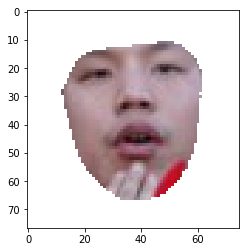

In [19]:
plt.imshow(np.concatenate([dst_face, mask[:, :, np.newaxis]], axis=2))

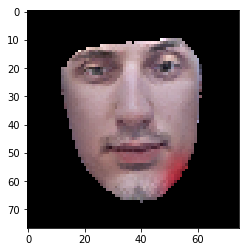

In [20]:
plt.imshow(warped_src_face)

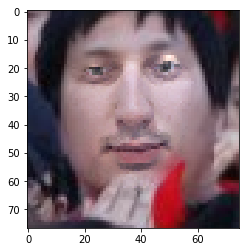

In [21]:
plt.imshow(new_output)

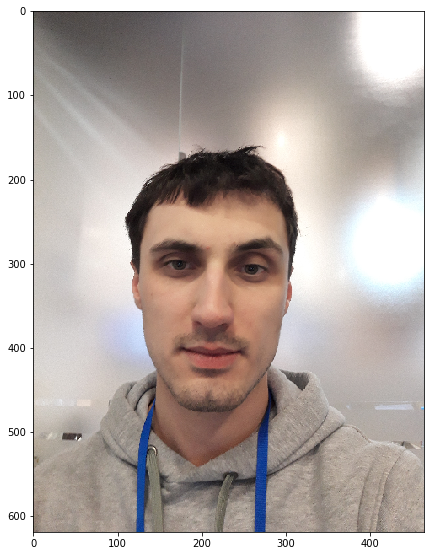

In [94]:
show_img(me)